In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 217.8MB 61kB/s 
     |████████████████████████████████| 204kB 41.1MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=66af1beded7916cd93f92b2cbc53483ea160e48d8f5f55138babc2607181b903
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark
openjdk-8-jdk-headless is already the newest version (8u242-b08-0ubuntu3~18.04).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [0]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [4]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2020-05-04 01:36:33--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.226.145.86, 52.87.72.17, 3.227.142.238, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.226.145.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  1.14MB/s    in 24s     

2020-05-04 01:37:04 (569 KB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
https://f57092bd.ngrok.io


Loading datasets

In [0]:
artists = sc.textFile('artists.txt')
#user_artists = sc.textFile('user_artists.txt')
user_artist_small = sc.textFile('user_artists_small.txt')
user_artist_synth = sc.textFile('user_artists_synthetic.txt')

In [6]:
artists_rdd = artists.map(lambda x:(x.split('\t')[0], x.split('\t')[1]))
header = artists_rdd.first()

artists = artists_rdd.filter(lambda row : row != header).toDF(header)
artists.show(5)

+--------+-----------------+
|artistID|             name|
+--------+-----------------+
|       0|     MALICE MIZER|
|       1|  Diary of Dreams|
|       2|Carpathian Forest|
|       3|     Moi dix Mois|
|       4|      Bella Morte|
+--------+-----------------+
only showing top 5 rows



In [7]:
#User_artist_small dataset
user_small_rdd = user_artist_small.map(lambda x:(x.split('\t')[0], x.split('\t')[1], x.split('\t')[2]))
header = user_small_rdd.first()

users_small = user_small_rdd.filter(lambda row : row != header).toDF(header)
users_small.count()

265

In [8]:
#user_artist_synthetic dataset
user_synth_rdd = user_artist_synth.map(lambda x:(x.split('\t')[0], x.split('\t')[1], x.split('\t')[2]))
header = user_synth_rdd.first()

user_synth = user_synth_rdd.filter(lambda row : row != header).toDF(header)
user_synth.count()

1954

UDF for computing SParsity ratio and ALS algorithm

In [0]:
def computeSparsityRatio(users, r, c):
  rows = [int(row.userID) for row in users.select('userID').collect()]
  cols = [int(row.artistID) for row in users.select('artistID').collect()]
  r_ui = [int(row.interactions) for row in users.select('interactions').collect()]

  sparseData = sparse.csr_matrix((r_ui, (rows, cols)), shape=(r, c)).toarray()

  alpha = float(np.count_nonzero(sparseData >0)/np.count_nonzero(sparseData ==0))
  
  return sparseData, alpha




In [0]:
def computeCost(Pu, Cu_imp, Pi, Ci_imp, X, Y, lamda):
  Pui = np.multiply(Pu, Pi)
  Cui = np.multiply(Cu_imp, Ci_imp)
  Z = np.dot(X, Y.T)
  L2 = lamda*(np.sum(np.square(X)) +  np.sum(np.square(Y)))
  cost = np.sum(np.multiply(Cui, np.square(Pui - Z))) + L2
  return cost


In [0]:
def computeImplicitALS(sparseData,alpha, lamda, f, max_iters =1000):
  #confidence
  C = sparseData * alpha
  C_implicit = []
  Pi = np.zeros(( sparseData.shape))
  Pu = np.zeros(( sparseData.shape))
  Ci_imp = np.zeros(( sparseData.shape))
  Cu_imp = np.zeros(( sparseData.shape))


  usersLen, itemLen = sparseData.shape

  X = np.zeros((usersLen, f))+0.5
  Y = np.zeros((itemLen, f))

  #lambda*I
  
 
  LI = lamda * sparse.eye(f)
  YI = sparse.eye(itemLen)
  XI = sparse.eye(usersLen)

  for k in range(max_iters):
    yTy = np.dot(Y.T, Y)
    xTx = np.dot(X.T, X)

    for i in range(itemLen):
      i_i = C[:, i].T
      p_i = i_i.copy()
      p_i[p_i != 0] = 1.0
      Ci = np.diag(i_i)
      Ciu = Ci + YI
      xT_Ci_x_LI = (xTx + np.dot(X.T, np.dot(Ciu, X))) + LI
      xT_Ci_p = np.dot(X.T, np.dot(Ci, p_i.T))
      Y[i] = np.dot(np.linalg.inv(xT_Ci_x_LI), xT_Ci_p)
      Pi[i] = p_i
      Ci_imp[i] = i_i
      if(i == 83):
        y_83 = Y[i]

    for u in range(usersLen):
      u_i = C[u, :]
      p_u = u_i.copy()
      p_u[p_u != 0] = 1.0
      Cu = np.diag(u_i)
      Cui = Cu + XI
      yT_Cu_y_LI = (yTy + np.dot(Y.T, np.dot(Cui, Y))) + LI
      yT_Cu_pu = np.dot(Y.T, np.dot(Cu, p_u.T))
      X[u] = np.dot(np.linalg.inv(yT_Cu_y_LI), yT_Cu_pu)
      Pu[u] = p_u
      Cu_imp[u] = u_i
      if(u == 30):
        x_30 = X[u]

    Cost = computeCost(Pu, Cu_imp, Pi, Ci_imp, X, Y, lamda)
    C_implicit.append(Cost)
    if(k <10):
      pui = np.dot(x_30.T, y_83)
      print("For Iteration",k+1,"p_30_83 = ", pui )

  return X,Y, C_implicit


Calculate sparsity ratio for the two datasets

In [12]:
#For user_artist_small data
r = 100
c= 100
SparseDataSmall, alpha_small = computeSparsityRatio(users_small, r, c)
alpha_small

0.027221366204417053

In [13]:
#For user_artist_synthetic data
r = 100
c= 100
SparseDataSynth, alpha_synth = computeSparsityRatio(user_synth, r, c)
alpha_synth

0.24285359184688043

Implicit recommendation system using ALS algorithm

In [32]:
#For user_artist_small data
lamda = 0.1
f = 5

X_users,Y_items, cost = computeImplicitALS(SparseDataSmall,alpha_small, lamda, f)

For Iteration 1 p_30_83 =  0.7467203121174106
For Iteration 2 p_30_83 =  0.48503956255112746
For Iteration 3 p_30_83 =  0.7813042645931054
For Iteration 4 p_30_83 =  -0.030479265849379433
For Iteration 5 p_30_83 =  -0.0059032928380542415
For Iteration 6 p_30_83 =  -0.08454620160717952
For Iteration 7 p_30_83 =  0.010184058520157468
For Iteration 8 p_30_83 =  0.015736676484060186
For Iteration 9 p_30_83 =  0.05972496945128469
For Iteration 10 p_30_83 =  0.06603006416976509


In [33]:
#Pui for u = 30 and I = 83 after 1000 iterations
X_u = X_users[30]
Y_i = Y_items[83]

pui = np.dot(X_u.T, Y_i)
pui

0.13767716578752315

In [35]:
#For user_artist_synth data
lamda = 0.1
f = 5

X_users,Y_items, cost_2 = computeImplicitALS(SparseDataSynth,alpha_synth, lamda, f)

For Iteration 1 p_30_83 =  0.017757140018249934
For Iteration 2 p_30_83 =  0.02156433187018421
For Iteration 3 p_30_83 =  0.019634813404576443
For Iteration 4 p_30_83 =  0.022839400733752065
For Iteration 5 p_30_83 =  0.02105638409534122
For Iteration 6 p_30_83 =  0.02285157926019685
For Iteration 7 p_30_83 =  -0.003650476112346382
For Iteration 8 p_30_83 =  0.01911327130416133
For Iteration 9 p_30_83 =  0.010138776579776236
For Iteration 10 p_30_83 =  0.021091454306038624


In [36]:
#Pui for u = 30 and I = 83 after 1000 iterations
X_u = X_users[30]
Y_i = Y_items[83]

pui = np.dot(X_u.T, Y_i)
pui

0.031263488981514015

Text(0.5, 1.0, 'User_artist_synthetic data')

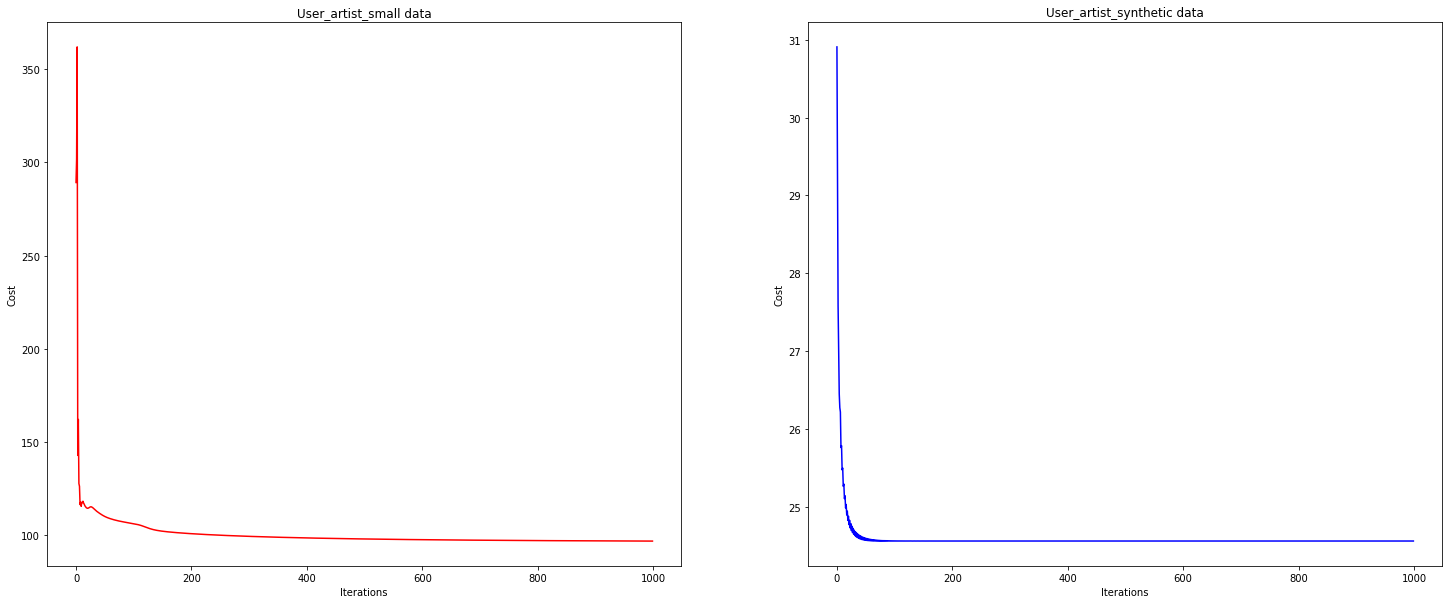

In [40]:
#plotting the ALS cost function vs iteration graph for the two datasets 
plt.figure(figsize = (25,10))

plt.subplot(1,2,1)
plt.plot(cost, color = "red")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("User_artist_small data")

plt.subplot(1,2,2)
plt.plot(cost_2, color = "blue")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("User_artist_synthetic data")